In [1]:
# Kaggle competition for House Prices in Ames, Iowa.
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques
   
__author__ = 'Mike DiPalma'
__email__ = 'mdipalma78@gmail.com'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from math import sqrt

In [3]:
def load_file(file):
    '''loads csv to pd dataframe'''
    return pd.read_csv(file)

def join_dataframes(train, test):    
    '''Joins two dataframes and resets the index'''
    joined_df = pd.concat([train, test], sort=False)
    joined_df = joined_df.reset_index(drop=True) # reset index
    return joined_df

def clean_dataframe(df, column):
    '''removes outliers, replaces NaN values and applies log1p transformation to SalePrice'''
    df = df.drop(df[(df['GrLivArea']>4000) & (df['SalePrice']<300000)].index)
    for col in ('LotFrontage', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'BsmtFinSF1', \
                'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath','BsmtHalfBath'):
        df[col].fillna(0.0, inplace=True)
    for col in ('Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', \
                'Electrical', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', \
                'Fence', 'MiscFeature'):
        df[col].fillna('None', inplace=True)
    df['log1p' + column] = np.log1p(df[column])
    return df

def transform_data_types(df):
    df['MSSubClass'] = df['MSSubClass'].apply(str)
    df['YrSold'] = df['YrSold'].astype(str)
    df['MoSold'] = df['MoSold'].astype(str)
    df['YearBuilt'] = df['YearBuilt'].astype(str)
    df['YearRemodAdd'] = df['YearRemodAdd'].astype(str)
    print("Transformed numerical features that should be considered as strings.")

def one_hot_encode_feature_df(df, cat_vars=None, num_vars=None, tar_var=None):
    '''performs one-hot encoding on all categorical variables and combines result with continous variables'''
    cat_df = pd.get_dummies(df[cat_vars], drop_first=True)
    num_df = df[num_vars].apply(pd.to_numeric)
    tar_df = df[tar_var].apply(pd.to_numeric)
    return pd.concat([cat_df, num_df, tar_df], axis=1)#,ignore_index=False)

def get_feature_df(df, target):
    '''from the clean joined df, prepares the features dataframe for modeling'''
    # Split training and test 
    train_df = df[df['log1pSalePrice'].notnull()]
    # Drop log1pSalePrice from training and test dataframes
    features_df = train_df.drop(['log1pSalePrice'], axis=1)
    return features_df

def get_test_df(df, target):
    '''from the clean joined df, prepare the test dataframe for modeling'''
    # Split training and test 
    test_df = df[df['log1pSalePrice'].isnull()]
    # Drop log1pSalePrice from training and test dataframes
    test_df = test_df.drop(['log1pSalePrice'], axis=1)
    return test_df

def get_target_df(df, target):
    '''returns target dataframe'''
    # Verify all test records are excluded 
    df = df[df['log1pSalePrice'].notnull()]
    return df[target]

def train_model(model, feature_df, target_df, num_procs, mean_rmse, cv_std):
    neg_mse = cross_val_score(model, feature_df, target_df, cv=2, n_jobs=num_procs, scoring='neg_mean_squared_error')
    cv_rmse_results = np.sqrt(-neg_mse)
    mean_rmse[model] = np.mean(cv_rmse_results)
    cv_std[model] = np.std(cv_rmse_results)

def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_rmse[model])
    print('Standard deviation during CV:\n', cv_std[model])
    
def save_results(model, mean_mse, predictions, feature_importances):
    '''saves model, model summary, feature importances, and predictions'''
    with open('model.txt', 'w') as file:
        file.write(str(model))
    feature_importances.to_csv('feature_importances.csv') 
    np.savetxt('predictions.csv', predictions, delimiter=',')
    
def create_submission(test_df, test_ID, preds):
    test_df['Id'] = test_ID.values.tolist()
    test_df['prediction'] = pd.Series(predictions, index=test_df.index)
    sub_df = pd.DataFrame({'Id': test_df.Id, 'SalePrice': test_df.prediction})

    timestr = time.strftime("%Y%m%d-%H%M%S") 

    sub_df.to_csv('submission-' + timestr + '.csv', index=False)

In [4]:
# Define inputs
train_file = 'data/train.csv'
test_file = 'data/test.csv'

#define variables
categorical_vars = ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', \
                    'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', \
                    'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', \
                    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', \
                    'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', \
                    'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', \
                    'SaleCondition', 'MSSubClass', 'YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold']
numeric_vars = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', \
                'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', \
                'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', \
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', \
                'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal' ]
target_var = 'SalePrice'

#load data
print("Loading data")
raw_train_df = load_file(train_file)
raw_test_df = load_file(test_file)

# Save the test ID columnn for the submission file
test_ID = raw_test_df['Id']

# Shuffle the training dataframe for better cross-validation performance
raw_train_df = shuffle(raw_train_df).reset_index()

# Combine train and test dataframes for consistency in encoding and replacing NaN values.
joined_df = join_dataframes(raw_train_df, raw_test_df)

# Transform numeric columns that should be strings
transform_data_types(joined_df)

# Clean data - remove outliers, replace NaN and log transform target
clean_joined_df = clean_dataframe(joined_df, 'SalePrice')

#reset target variable to log1p version of SalePrice
target_var = 'log1pSalePrice'

# One-hot encode categorical values
print("Encoding data")
final_joined_df = one_hot_encode_feature_df(clean_joined_df, cat_vars=categorical_vars, num_vars=numeric_vars, tar_var=target_var)

# Get test dataframe
test_df = get_test_df(final_joined_df, target_var)

# Get features dataframe
feature_df = get_feature_df(final_joined_df, target_var)

#get target df
target_df = get_target_df(final_joined_df, target_var)

Loading data
Transformed numerical features that should be considered as strings.
Encoding data


In [5]:
#initialize model list and dicts
models = []
mean_rmse = {}
cv_std = {}
res = {}

#define number of processes to run in parallel
num_procs = 2

#shared model paramaters
verbose_lvl = 0

In [7]:
#create models -- hyperparameter tuning already done by hand for each model
lr = LinearRegression()
lr_std_pca = make_pipeline(StandardScaler(), PCA(), LinearRegression())
rf = RandomForestRegressor(n_estimators=150, n_jobs=num_procs, max_depth=25, min_samples_split=60, \
                           max_features=30, verbose=verbose_lvl)
gbm = GradientBoostingRegressor(n_estimators=150, max_depth=5, loss='ls', verbose=verbose_lvl)
                      
models.extend([lr, lr_std_pca, rf, gbm])

#parallel cross-validate models, using MSE as evaluation metric, and print summaries
print("Beginning cross validation")
for model in models:
    train_model(model, feature_df, target_df, num_procs, mean_rmse, cv_std)
    print_summary(model, mean_rmse, cv_std)



Beginning cross validation

Model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Average MSE:
 0.20473109884227964
Standard deviation during CV:
 0.0025110187821631436

Model:
 Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=None,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('linearregression',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Average MSE:
 103517493845.86737
Standard deviation during CV:
 66399184306.45688

Model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
                      max_features=30, max_leaf_nodes=None,
                      min_impurity_de

In [8]:
#choose model with lowest mse
model = min(mean_rmse, key=mean_rmse.get)
print('\nPredictions calculated using model with lowest MSE:')
print(model)

#train model on entire dataset
model.fit(feature_df, target_df)

#create predictions based on test data
predictions = np.expm1(model.predict(test_df))


Predictions calculated using model with lowest MSE:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [9]:
#store feature importances
if hasattr(model, 'feature_importances_'):
    importances = model.feature_importances_
else:
    #linear models don't have feature_importances_
    importances = [0]*len(feature_df.columns)
    
feature_importances = pd.DataFrame({'feature':feature_df.columns, 'importance':importances})
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
#set index to 'feature'
feature_importances.set_index('feature', inplace=True, drop=True)

#save results
save_results(model, mean_rmse[model], predictions, feature_importances)

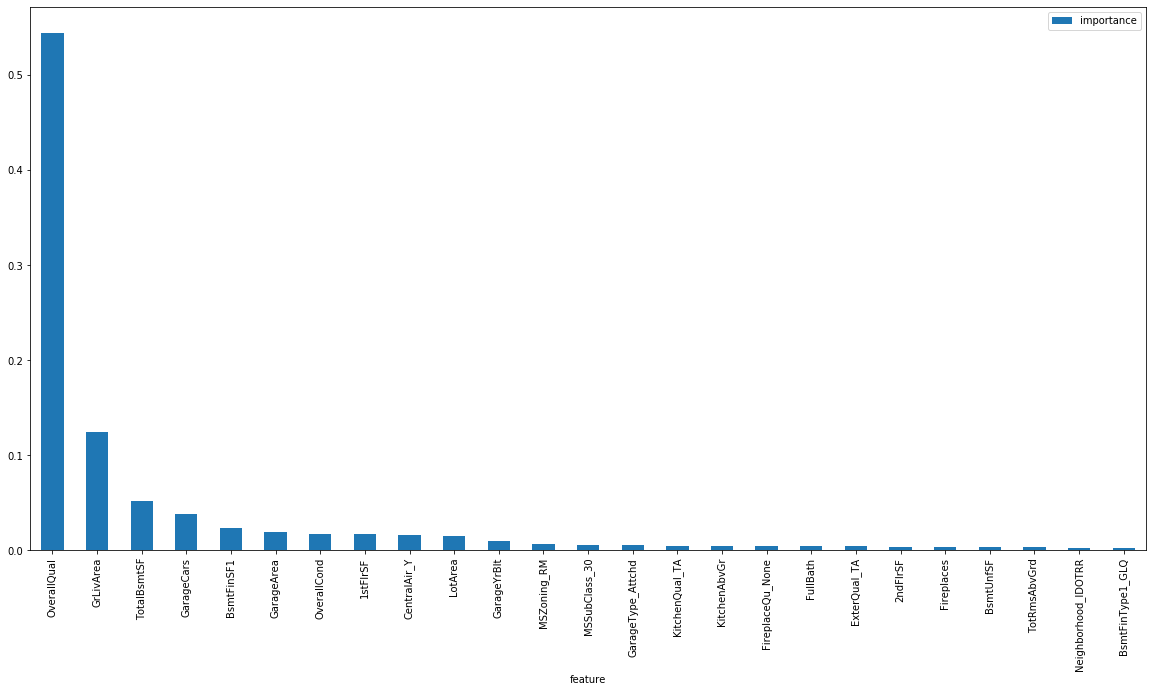

In [10]:
feature_importances[0:25].plot.bar(figsize=(20,10))
plt.show()

In [11]:
!cat model.txt

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=150,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
!head feature_importances.csv

feature,importance
OverallQual,0.5445203294711064
GrLivArea,0.12484795275063904
TotalBsmtSF,0.05202833317400822
GarageCars,0.038563002791448364
BsmtFinSF1,0.023829900255212224
GarageArea,0.019305536039646957
OverallCond,0.01748288529944407
1stFlrSF,0.017476626442783662
CentralAir_Y,0.016393066969387093


In [13]:
!head predictions.csv

1.197928682830985344e+05
1.553612639795145660e+05
1.829623346516409074e+05
1.880007696396223619e+05
1.854903374507589615e+05
1.702423919575684995e+05
1.655112957712933712e+05
1.645695089144066151e+05
1.824951676969634136e+05
1.241182894164236641e+05


In [14]:
create_submission(test_df, test_ID, predictions)